# 2. Data Containers

Now we have seen how we can search for and download data - lets now look at how we can read this data in.

SunPy provides core data type classes that are designed to provide a consistent interface across data types (timeseries and images) as well as data sources from numerous instruments and observations. They handle all of the manipulation necessary to read data in from mission-specific files. The two main datatypes in SunPy are

1. `TimeSeries`  
2. `Map`

In [191]:
import sunpy.map
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch


import matplotlib.pyplot as plt
from matplotlib import colors
import glob
import numpy as np

## 2.1 TimeSeries

The structure of a [`TimeSeries`](https://docs.sunpy.org/en/stable/guide/data_types/timeseries.html) consists of times and measurements and the underlying structure is that of a `pandas.DataFrame`. 

SunPy TimeSeries supports time-series data from a wide range of solar-focused instruments. `TimeSeries` can either be created manually or from source files that are currently supported. If a supported file is passed to `TimeSeries` it will automatically detect its source and its instrument-specific meta data will be loaded. 

Lets create a timeseries from out sample data which is X-ray flux from the GOES X-ray Sensor Data. This data file was downloaded locally in the steps previously! 

In [192]:
xrs = sunpy.timeseries.TimeSeries('sci_xrsf-l2-flx1s_g16_d20220328_v2-1-0.nc')

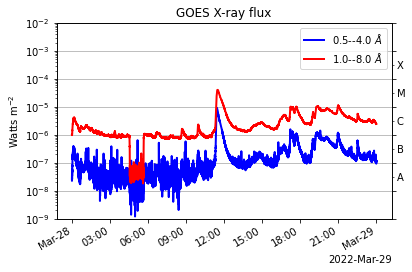

In [193]:
xrs.peek()

### Inspect the TimeSeries

Lets now inspect the TimeSeries and get at the data. A timeseries holds data as well as meta data and unit data.

In [194]:
xrs.units

OrderedDict([('xrsa', Unit("W / m2")), ('xrsb', Unit("W / m2"))])

In [195]:
xrs.meta

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2022-03-27T23:59:59.803944 | xrsa            | conventions: ACDD-1.3, Spase v2.2.6               |
|            to             | xrsb            | title: L2 XRS 1-s fluxes                          |
|2022-03-28T23:59:59.053007 |                 | summary: The X-Ray 1s flux product consists of hig|
|                           |                 | keywords: NumericalData.MeasurementType.Irradiance|
|                           |                 | keywords_vocabulary: SPASE: Space Physics Archive |
|                           |                 | naming_authority: gov.nesdis.noaa                 |
|                           |                 | history: See algorithm information.               |


The TimeSeries object can also be converted to other formats like a pandas DataFrame or an astropy Table object


In [196]:
xrs.to_dataframe()

,xrsa,xrsb
2022-03-27 23:59:59.803944,2.704667e-08,9.829366e-07
2022-03-28 00:00:00.803945,3.564548e-08,9.919180e-07
2022-03-28 00:00:01.803948,3.458229e-08,9.912862e-07
2022-03-28 00:00:02.803952,3.567656e-08,9.790778e-07
2022-03-28 00:00:03.803955,3.028288e-08,9.867955e-07
...,...,...
2022-03-28 23:59:55.053000,1.047156e-07,2.473760e-06
2022-03-28 23:59:56.053001,1.165817e-07,2.477619e-06
2022-03-28 23:59:57.053003,9.394382e-08,2.493067e-06
2022-03-28 23:59:58.053004,1.057944e-07,2.478905e-06


In [197]:
xrs.to_table()

date,xrsa,xrsb
,W / m2,W / m2
datetime64[ns],float32,float32
2022-03-27T23:59:59.803944000,2.7046674e-08,9.829366e-07
2022-03-28T00:00:00.803945000,3.564548e-08,9.91918e-07
2022-03-28T00:00:01.803948000,3.4582285e-08,9.912862e-07
2022-03-28T00:00:02.803952000,3.5676557e-08,9.790778e-07
2022-03-28T00:00:03.803955000,3.028288e-08,9.867955e-07
...,...,...
2022-03-28T23:59:55.053000000,1.0471562e-07,2.47376e-06
2022-03-28T23:59:56.053001000,1.1658171e-07,2.477619e-06


there are also a number of attributes on each TimeSeries derived from the data/metadata.

In [198]:
xrs.columns

['xrsa', 'xrsb']

In [199]:
xrs.observatory

'GOES-16'

## Manipulating the timeseries data

We can manipulate the timeseries, such as truncating (slicing) the data over a certain time period

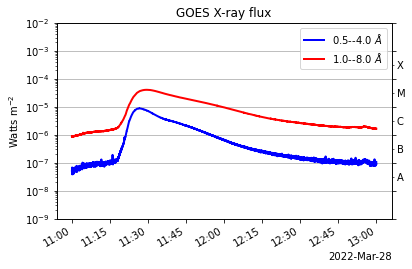

In [200]:
xrs.truncate("2022-03-28 11:00", "2022-03-28 13:00").peek()

you can also convert to a pandas.DataFrame and then use the functionality there such as resampling etc

In [201]:
xrs_df = xrs.to_dataframe()


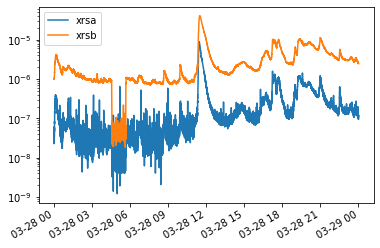

In [202]:
xrs_df.plot()
plt.yscale("log")

In [203]:
xrs_df_resample = xrs_df.resample("60s").mean()

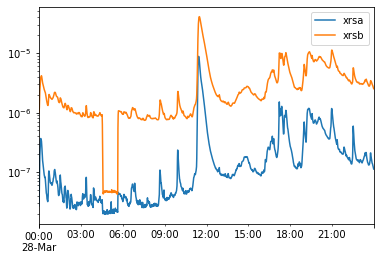

In [204]:
xrs_df_resample.plot()
plt.yscale("log")

## Solar Orbiter timeseries example

You can also pass a list of files to timeseries, and uses the `concatenate` keyword to create one continous timeseries. 

In [205]:
mag_files = glob.glob("*.cdf")

mag_solo = sunpy.timeseries.TimeSeries(mag_files, concatenate=True)


In [206]:
mag_solo.columns

['B_RTN_0',
 'B_RTN_1',
 'B_RTN_2',
 'QUALITY_BITMASK',
 'QUALITY_FLAG',
 'VECTOR_RANGE',
 'VECTOR_TIME_RESOLUTION']

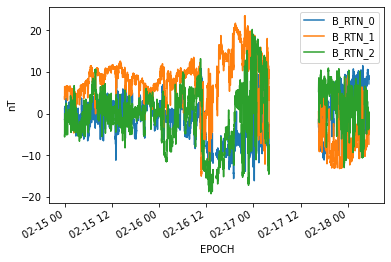

In [207]:
mag_solo.peek(['B_RTN_0', 'B_RTN_1', 'B_RTN_2'])

# 2.2 Map
The sunpy [`Map`](https://docs.sunpy.org/en/stable/guide/data_types/maps.html) class provides the data type structure to store 2-dimensional data associated with a coordinate system.  This allows users to store and manipulate images of the Sun and the heliosphere

Maps from all instruments are created using the `sunpy.map.Map` 'factory'. This class takes a wide variety of map-like inputs, for one or more maps and returns you one or many maps. All maps, irrespective of the instrument, behave the same and expose the same functions and properties, however, depending on the instrument different metadata might be read or corrections made.

In [208]:
aia_files = glob.glob("./AIA/*.fits"); aia_files.sort()

In [209]:
eui_files = glob.glob("./EUI/*.fits"); eui_files.sort()

In [210]:
aia_map = sunpy.map.Map(aia_files[0])

We can easily visualize a map after loading it using the quicklook functionality.

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2022-03-28 11:00:05
Exposure Time,2.902046 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2067.137451 2005.397705] pix

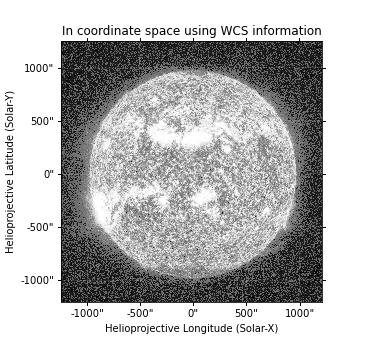
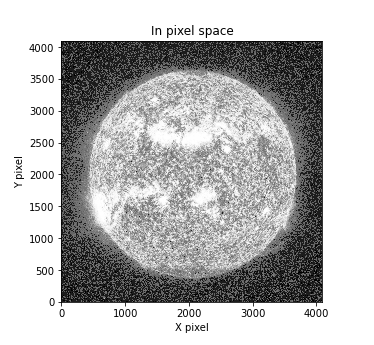
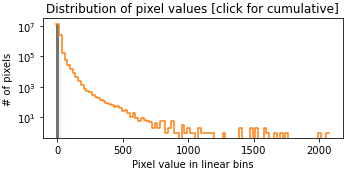
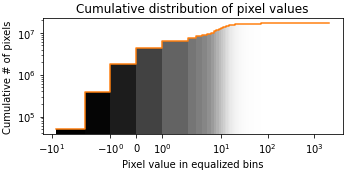

In [211]:
aia_map

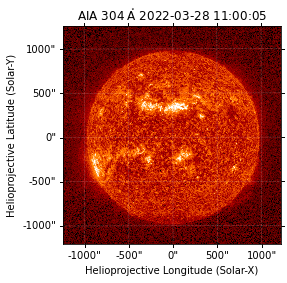

In [212]:
aia_map.plot(clip_interval=[1, 99.9]*u.percent)

Map provides customized loaders for a number of different instruments, however, if the data file follows the FITS data standards for coordinate information etc then map should be able to read it by default.

## Attributes of Map

Map provides a common interface to most 2D imaging solar datasets and provides several useful pieces of metadata. As mentioned in the intro slide, Map is a container for holding your data and metadata (usually from the FITS header) together.

The `.meta` and `.data` attributes provide access to the metadata and underlying array of image data, respectively.


In [213]:
aia_map.data

array([[ 0,  1, -1, ...,  0,  0,  0],
       [ 0,  1, -1, ...,  1, -1, -1],
       [ 1,  2,  0, ...,  0,  0,  0],
       ...,
       [ 0, -1,  0, ...,  0,  2,  0],
       [-1, -2, -2, ...,  0,  0,  0],
       [-2,  1,  0, ...,  1, -1, -1]], dtype=int16)

In [214]:
aia_map.meta

MetaDict([('simple', True),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('xtension', 'BINTABLE'),
          ('bld_vers', 'V9R41X'),
          ('lvl_num', 1.0),
          ('t_rec', '2022-03-28T11:00:07Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2022-04-01T05:55:19'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_4'),
          ('date-obs', '2022-03-28T11:00:05.13'),
          ('t_obs', '2022-03-28T11:00:06.58Z'),
          ('camera', 4),
          ('img_type', 'LIGHT'),
          ('exptime', 2.902046),
          ('expsdev', 0.0002),
          ('int_time', 3.148438),
          ('wavelnth', 304),
          ('waveunit', 'angstrom'),
          ('wave_str', '304_THIN'),
          ('fsn', 253114639),
          ('fid', 0),
          



However, this metadata can be terse, non-homogeneous, and sometimes difficult to parse. Map provides several attributes derived from the underlying raw metadata that expose a uniform interface to the metadata for each map.


In [215]:
aia_map.wavelength

<Quantity 304. Angstrom>

In [216]:
aia_map.rsun_meters

<Quantity 6.96e+08 m>

In [217]:
aia_map.processing_level

1.0

In [218]:
aia_map.unit

Unit("ct")

## Coordinate Information

Each Map also exposes information about which coordinate system the image was taken in, including the location of the spacecraft that recorded that observation.

`sunpy` leverages and extends the powerful astropy coordinate framework that we heard about in the previous tutorial. Additionally, we'll talk more about the sunpy.coordinates subpackage in the next notebook and show some neat examples.

For each `Map`, we can easily access what coordinate frame the observation cooresponds to.


In [219]:
aia_map.coordinate_frame

<Helioprojective Frame (obstime=2022-03-28T11:00:05.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-28T11:00:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.009972, -6.72416806, 1.4932589e+11)>)>

In [220]:
aia_map.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:00:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.009972, -6.72416806, 1.4932589e+11)>

## Inspecting and Manipulating the data

In [221]:
aia_map.data.shape

(4096, 4096)

In [222]:
aia_map.data[0][0]

0

In [223]:
print("Mean:", aia_map.mean(), "Max:", aia_map.max(), "Min:", aia_map.min(),  "Std:", aia_map.std())

Mean: 6.53083860874176 Max: 2073 Min: -8 Std: 11.104530041297519


## Rotate a map

The `.rotate` method applies a rotation in the image plane, i.e. about an axis out of the page. In the case where we do not specify an angle (or rotation matrix), the image will be rotated such that the world and pixel axes are aligned. In the case of an image in helioprojective coordinate system, this means that solar north will be aligned with the y-like pixel axis of the image

In [224]:
aia_map_rot = aia_map.rotate(angle=30*u.degree, missing=aia_map.min())

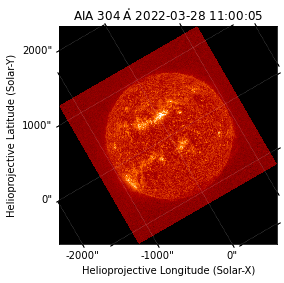

In [225]:
aia_map_rot.plot(clip_interval=(1, 99.99)*u.percent)

## World and Pixel Coordinates

We can convert between the world coordinates (arcsec) to pixel coordinates using the world_to_pixel method on map which takes a SkyCoord and then returns the pixel coordinate. Similarly we can find the world coordinate to the pixel (or array) index. This is done with the pixel_to_world method. Lets first look at finding the array (pixel) index for the center of the Sun (0, 0) arcsec:


In [226]:
aia_map.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=aia_map.coordinate_frame))

PixelPair(x=<Quantity 2067.137451 pix>, y=<Quantity 2005.397705 pix>)

In [227]:
max_pixel_pos = np.argwhere(aia_map.data==aia_map.max())[0]
max_pixel_pos

array([2547, 2222])

In [228]:
max_coord = aia_map.pixel_to_world(max_pixel_pos[1]*u.pixel, max_pixel_pos[0]*u.pixel)
max_coord

<SkyCoord (Helioprojective: obstime=2022-03-28T11:00:05.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-28T11:00:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.009972, -6.72416806, 1.4932589e+11)>): (Tx, Ty) in arcsec
    (93.68982586, 324.83598938)>

## Plotting a Map

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

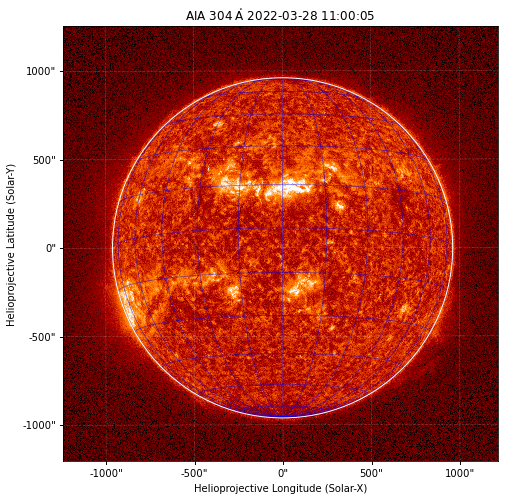

In [229]:
fig = plt.figure(figsize=(8, 8))
aia_map.plot(clip_interval=[1, 99.9]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid(color='b')

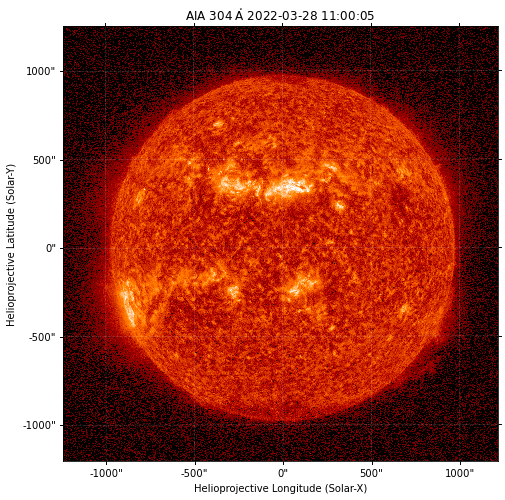

In [230]:
norm = ImageNormalize(vmin=0, vmax=200, stretch=LogStretch())
plt.figure(figsize=(8,8))
aia_map.plot(norm=norm)

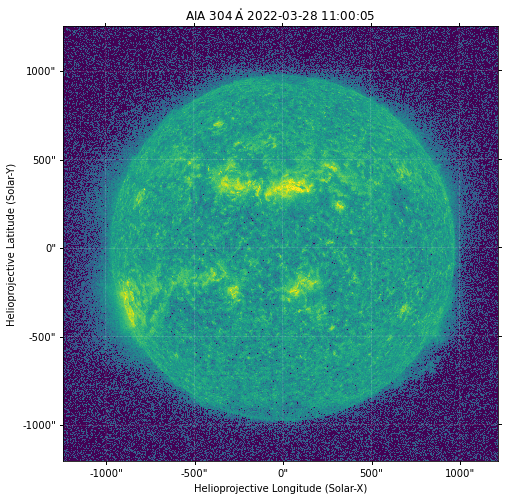

In [231]:
norm = ImageNormalize(vmin=0, vmax=200, stretch=LogStretch())
plt.figure(figsize=(8,8))
aia_map.plot(norm=norm, cmap="viridis")

# Crop a map

We commonly want to pare down our full field-of-view to a particular region of interest.
With a map, we can do this using the `submap` method.

We can specify the region of our submap using world coordinates as specified by a `SkyCoord`.
These coordinates can be specified in different coordinate systems and still should work (e.g. helioprojective or heliograhic stonyhurst)


In [232]:
bottom_left = SkyCoord(-300*u.arcsec, 20*u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(390*u.arcsec, 650*u.arcsec, frame=aia_map.coordinate_frame)

In [233]:
submap = aia_map.submap(bottom_left, top_right=top_right)

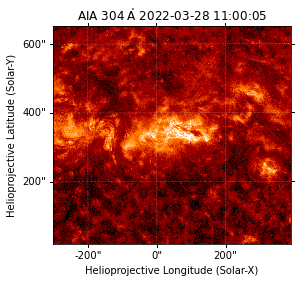

In [234]:
fig = plt.figure()
submap.plot(clip_interval=[1, 99.9]*u.percent)

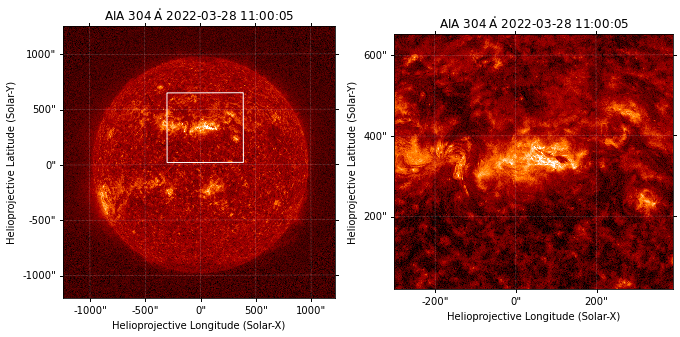

In [235]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=(0.1, 99.99)*u.percent)
# draw rectangle on the map
aia_map.draw_quadrangle(bottom_left, top_right=top_right, 
                        axes=ax1)

ax2 = fig.add_subplot(1,2,2,projection=submap)
submap.plot(clip_interval=(0.5, 99.95)*u.percent)



## WCS axes and plotting

SunPy map uses the [`astropy.visualization.wcsaxes`](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html#module-astropy.visualization.wcsaxes) module to represent world coordinates. 

Using WCSAxes is very powerful but has important concepts to think about:

 * **`world`** coordinates refer to the coordinates of the coordinate system - i.e. arcsec, degrees!
 * **`pixel`** coordinates refer to the array index of the data! i.e. data[10] etc
 
 
When plotting on WCSAxes it will by default plot in pixel coordinates, you can override this behavior and plot in `world` coordinates by getting the transformation from the axes with `ax.get_transform('world')`. We will use some of these examples below. Its also important to note that when using the `world` coordinates these have to be in **degrees** so make sure to convert arcsec's to degrees.


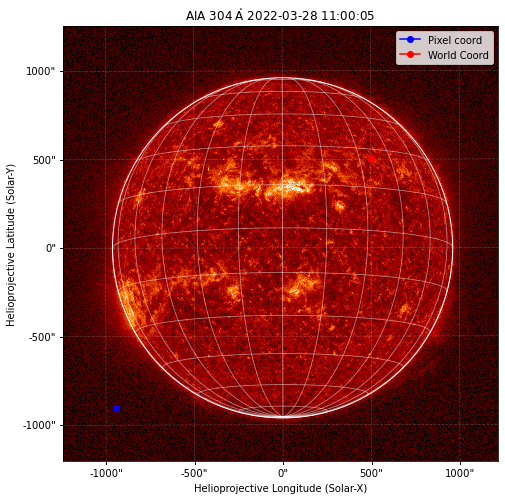

In [236]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=aia_map)  

# plot the map
aia_map.plot(clip_interval=[0.5, 99.99]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid()

# plot in pixel coordinates
ax.plot(500, 500, marker='o', color="b",  label="Pixel coord")

# plot in world coordinates
ax.plot((500*u.arcsec).to(u.deg), (500*u.arcsec).to(u.deg),
        transform=ax.get_transform('world'), 
        marker='o',color="r", label="World Coord")

ax.legend()



You can also plot SkyCoords on a Map. Importantly, this can be done with ax.plot_coord and the coordinate does not need to be transformed to the same coordinate frame as the map - it is done automatically if it can be


In [237]:
coord1 = SkyCoord(200*u.arcsec, -500*u.arcsec, frame=aia_map.coordinate_frame)
coord2 = SkyCoord(20*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst)

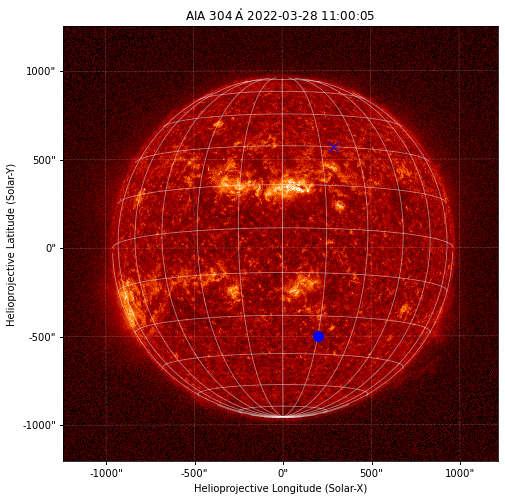

In [238]:


fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=[0.5, 99.99]*u.percent)

aia_map.draw_grid(axes=ax)

ax.plot_coord(coord1, marker='o', ms=10, color='b')
ax.plot_coord(coord2, marker='x', ms=10, color='b')



## Saving a map

In [246]:
submap.save("my_submap.fits")

In [247]:
my_submap = sunpy.map.Map("my_submap.fits")

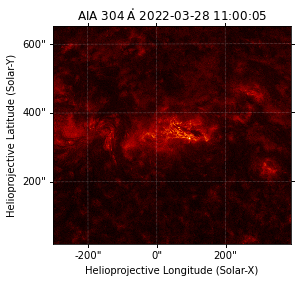

In [248]:
my_submap.plot()